In [485]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [486]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [487]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [488]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [489]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    print(id_[:2])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + '1st_manual/' + id_[:2] + '_manual1.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + '1st_manual/' + id_[:2] + '_manual1.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

21
22


C:\Users\manda\AppData\Local\Temp\ipykernel_4400\452691114.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
 10%|████████▎                                                                          | 2/20 [00:00<00:01, 12.73it/s]

23


 20%|████████████████▌                                                                  | 4/20 [00:00<00:01, 12.84it/s]

24
25
26


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01, 12.71it/s]

27
28


 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 12.80it/s]

29


 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 12.86it/s]

30
31


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:00<00:00, 12.95it/s]

32
33
34


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00, 12.64it/s]

35


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:01<00:00, 12.37it/s]

36
37
38


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.86it/s]

39
40


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.75it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_4400\452691114.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.96it/s]


In [490]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


C:\Users\manda\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


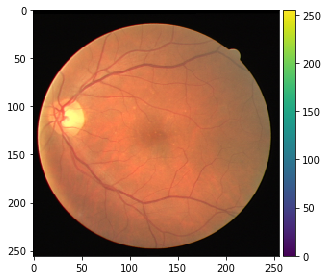

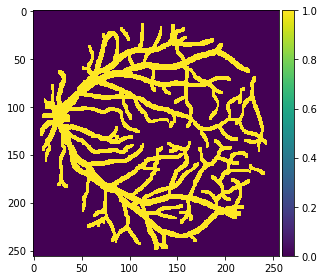

In [491]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

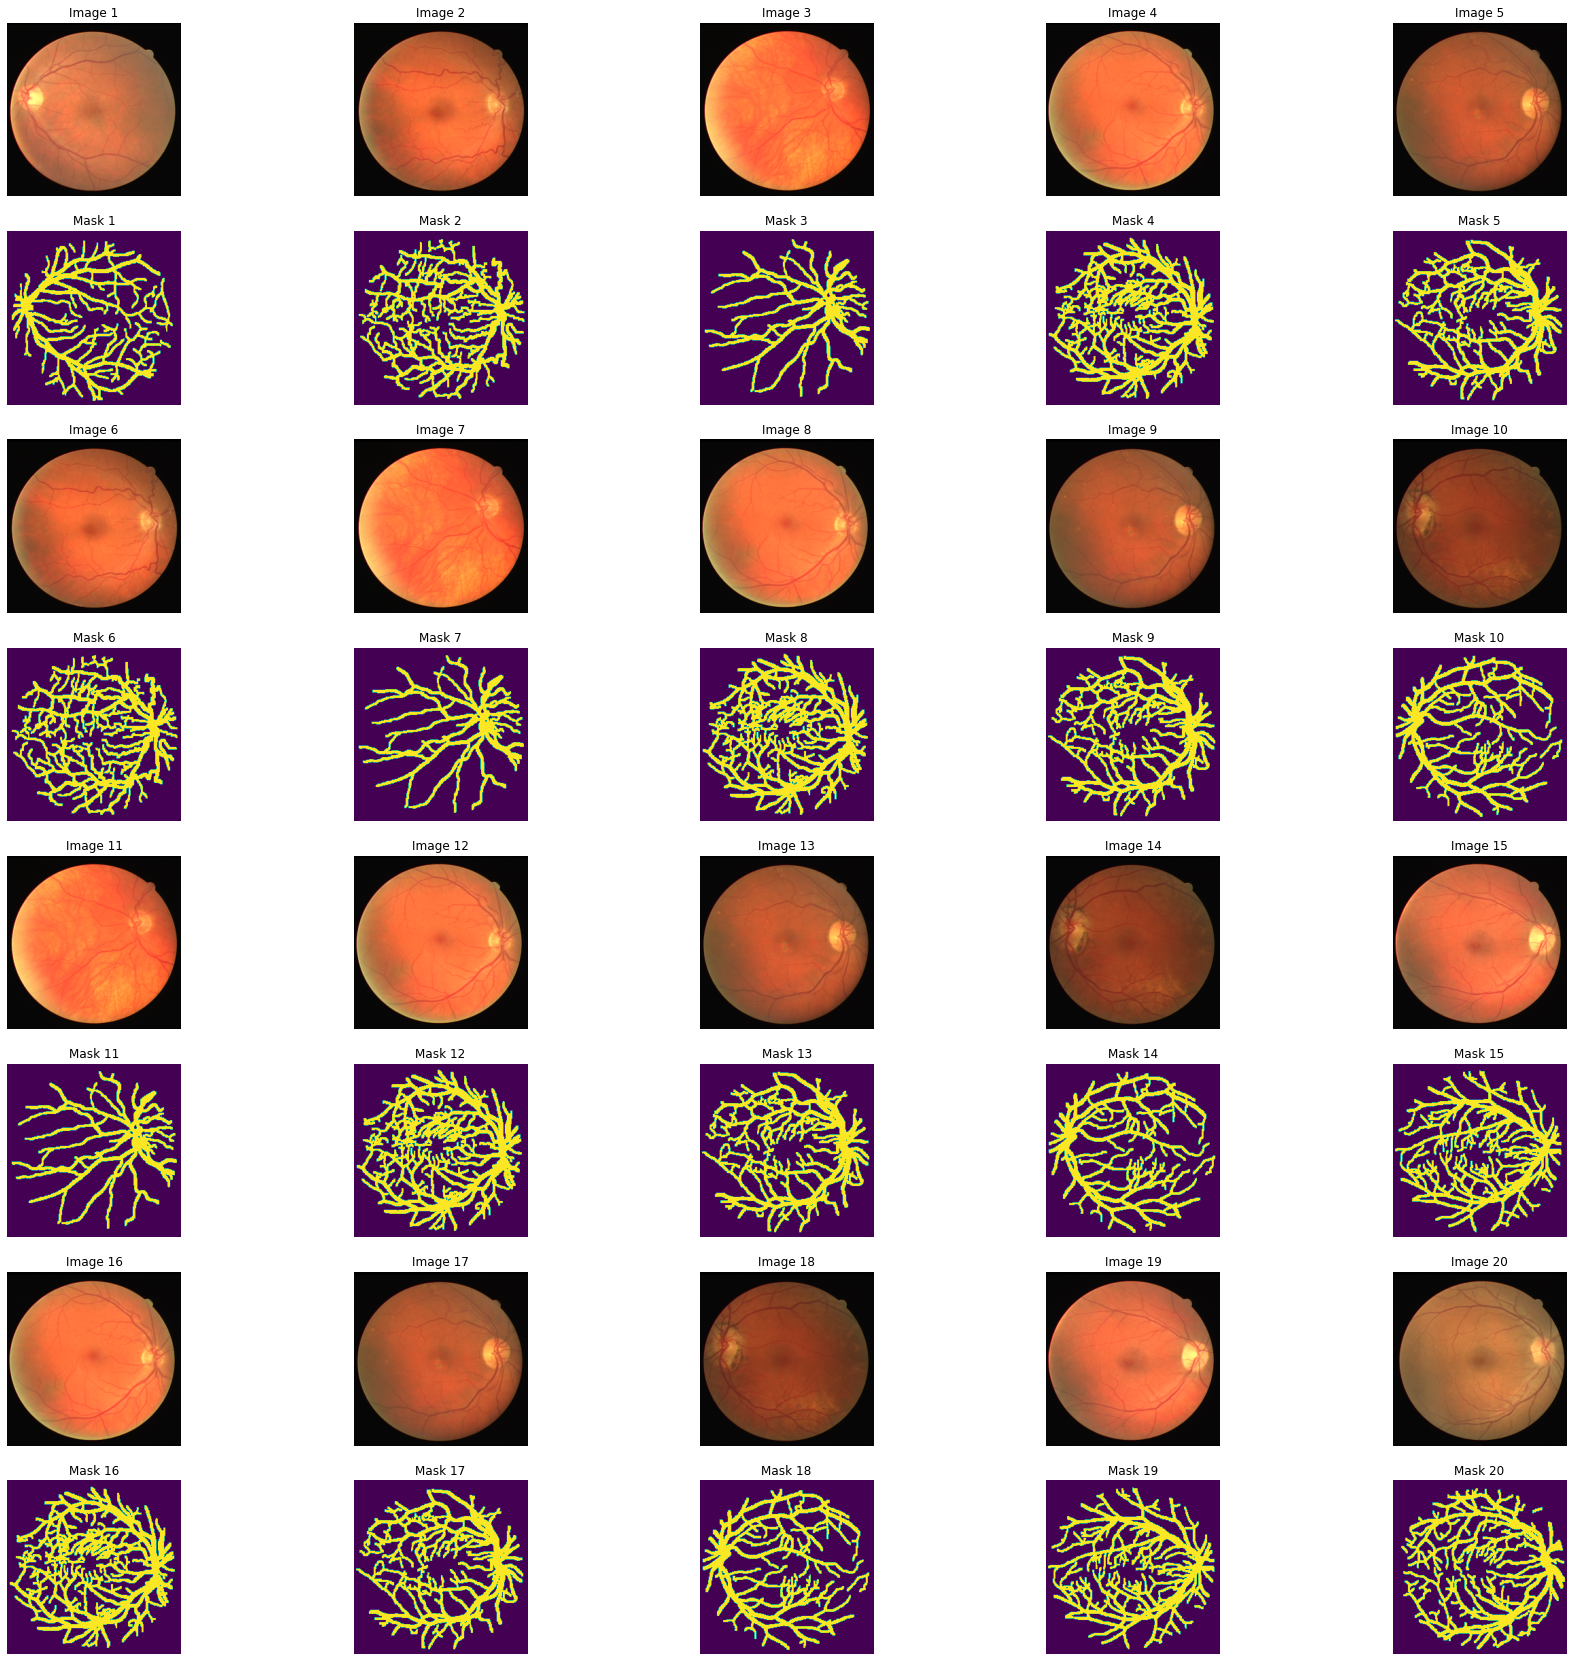

In [492]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [493]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [494]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [495]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

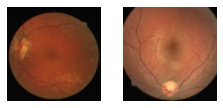

In [496]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

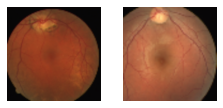

In [497]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [498]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [499]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [500]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [501]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

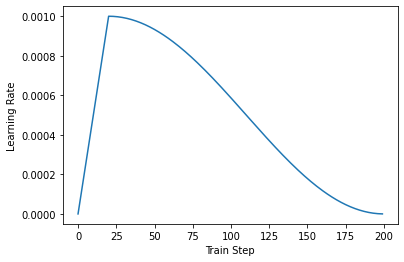

In [502]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [503]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    #s = inputs
    x, skip_1 = encoder(s)
    
    x = bottleneck(x)
    
    # Projections
    trunk_output = GlobalAvgPool2D()(x)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    model = Model(inputs, projection_outputs)
    return model, skip_1

In [504]:
unet_enc, skip_connetions = build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=PROJECT_DIM)
unet_enc.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_12 (Rescaling)       (None, 256, 256, 3)  0           ['input_13[0][0]']               
                                                                                                  
 separable_conv2d_216 (Separabl  (None, 256, 256, 16  91         ['rescaling_12[0][0]']           
 eConv2D)                       )                                                                 
                                                                                           

 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_367 (Batch  (None, 64, 64, 64)  256         ['separable_conv2d_221[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 conv2d_122 (Conv2D)            (None, 64, 64, 64)   2112        ['max_pooling2d_49[0][0]']       
                                                                                                  
 activation_257 (Activation)    (None, 64, 64, 64)   0           ['batch_normalization_367[0][0]']
                                                                                                  
 batch_normalization_368 (Batch  (None, 64, 64, 64)  256         ['conv2d_122[0][0]']             
 Normaliza

                                                                                                  
 activation_262 (Activation)    (None, 128)          0           ['batch_normalization_375[0][0]']
                                                                                                  
 projection_layer_1 (Dense)     (None, 128)          16512       ['activation_262[0][0]']         
                                                                                                  
 batch_normalization_376 (Batch  (None, 128)         512         ['projection_layer_1[0][0]']     
 Normalization)                                                                                   
                                                                                                  
 activation_263 (Activation)    (None, 128)          0           ['batch_normalization_376[0][0]']
                                                                                                  
 projectio

Training
Epoch 1/100
5/5 [==============================] - 12s 1s/step - loss: 68.2419
Epoch 2/100
5/5 [==============================] - 7s 1s/step - loss: 35.7989
Epoch 3/100
5/5 [==============================] - 6s 1s/step - loss: 35.3229
Epoch 4/100
5/5 [==============================] - 6s 1s/step - loss: 32.7256
Epoch 5/100
5/5 [==============================] - 6s 1s/step - loss: 32.4630
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 33.3348
Epoch 7/100
5/5 [==============================] - 6s 1s/step - loss: 29.6366
Epoch 8/100
5/5 [==============================] - 6s 1s/step - loss: 32.3173
Epoch 9/100
5/5 [==============================] - 6s 1s/step - loss: 30.0658
Epoch 10/100
5/5 [==============================] - 6s 1s/step - loss: 32.3775
Epoch 11/100
5/5 [==============================] - 6s 1s/step - loss: 31.2217
Epoch 12/100
5/5 [==============================] - 6s 1s/step - loss: 35.2941
Epoch 13/100
5/5 [==============================] -

INFO:tensorflow:Assets written to: barlow_twins_unet\assets


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


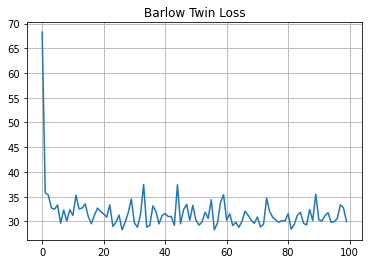

In [505]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)
    barlow_twins.encoder.save('barlow_twins_unet')
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights('barlow_twins_unet')

In [506]:
backbone = tf.keras.Model(
    barlow_twins.encoder.input, barlow_twins.encoder.layers[-9].output
)
backbone.layers

In [507]:
backbone.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_12 (Rescaling)       (None, 256, 256, 3)  0           ['input_13[0][0]']               
                                                                                                  
 separable_conv2d_216 (Separabl  (None, 256, 256, 16  91         ['rescaling_12[0][0]']           
 eConv2D)                       )                                                                 
                                                                                           

 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_367 (Batch  (None, 64, 64, 64)  256         ['separable_conv2d_221[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 conv2d_122 (Conv2D)            (None, 64, 64, 64)   2112        ['max_pooling2d_49[0][0]']       
                                                                                                  
 activation_257 (Activation)    (None, 64, 64, 64)   0           ['batch_normalization_367[0][0]']
                                                                                                  
 batch_normalization_368 (Batch  (None, 64, 64, 64)  256         ['conv2d_122[0][0]']             
 Normaliza

In [508]:
new_skip_connections = [backbone.get_layer(index=11).output, 
                        backbone.get_layer(index=22).output, 
                        backbone.get_layer(index=33).output, 
                        backbone.get_layer(index=44).output]

In [509]:
new_skip_connections

[<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'add_108')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'add_109')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'add_110')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'add_111')>]

In [510]:
backbone.output

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'add_112')>

In [511]:
backbone.trainable=True
x = backbone.output
#x = bottleneck(x)
x = decoder(x, new_skip_connections)
outputs = output(x)
model = Model(barlow_twins.encoder.input, outputs)

In [512]:
model.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_12 (Rescaling)       (None, 256, 256, 3)  0           ['input_13[0][0]']               
                                                                                                  
 separable_conv2d_216 (Separabl  (None, 256, 256, 16  91         ['rescaling_12[0][0]']           
 eConv2D)                       )                                                                 
                                                                                           

 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_367 (Batch  (None, 64, 64, 64)  256         ['separable_conv2d_221[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 conv2d_122 (Conv2D)            (None, 64, 64, 64)   2112        ['max_pooling2d_49[0][0]']       
                                                                                                  
 activation_257 (Activation)    (None, 64, 64, 64)   0           ['batch_normalization_367[0][0]']
                                                                                                  
 batch_normalization_368 (Batch  (None, 64, 64, 64)  256         ['conv2d_122[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_377 (Batch  (None, 32, 32, 128)  512        ['separable_conv2d_226[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 activation_264 (Activation)    (None, 32, 32, 128)  0           ['batch_normalization_377[0][0]']
                                                                                                  
 separable_conv2d_227 (Separabl  (None, 32, 32, 128)  17664      ['activation_264[0][0]']         
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_378 (Batch  (None, 32, 32, 128)  512        ['separable_conv2d_227[0][0]']   
 Normaliza

 batch_normalization_385 (Batch  (None, 128, 128, 32  128        ['conv2d_127[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 dropout_115 (Dropout)          (None, 128, 128, 32  0           ['activation_269[0][0]']         
                                )                                                                 
                                                                                                  
 add_115 (Add)                  (None, 128, 128, 32  0           ['batch_normalization_385[0][0]',
                                )                                 'dropout_115[0][0]']            
                                                                                                  
 up_sampling2d_51 (UpSampling2D  (None, 256, 256, 32  0          ['add_115[0][0]']                
 )        

In [513]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

In [514]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [515]:
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [516]:
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Training
Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.3832 - precision_120: 0.1522 - mean_io_u_120: 0.3614 - recall_120: 0.2680 - dice_coeff: 0.2827 - mean_absolute_error: 0.5578 - my_haud_dist: 9.1789 - my_iou_metric: 0.0000e+00
Epoch 1: loss improved from inf to 0.43040, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 12s 12s/step - loss: 0.4304 - accuracy: 0.3832 - precision_120: 0.1522 - mean_io_u_120: 0.3614 - recall_120: 0.2680 - dice_coeff: 0.2827 - mean_absolute_error: 0.5578 - my_haud_dist: 9.1789 - my_iou_metric: 0.0000e+00 - val_loss: 0.3408 - val_accuracy: 0.3165 - val_precision_120: 0.2783 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9522 - val_dice_coeff: 0.4320 - val_mean_absolute_error: 0.5829 - val_my_haud_dist: 9.5012 - val_my_iou_metric: 0.0000e+00 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.6211 - precision_120: 0.3995 - mean_io_u_120: 0.3

Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.6140 - precision_120: 0.4148 - mean_io_u_120: 0.3614 - recall_120: 0.9558 - dice_coeff: 0.4706 - mean_absolute_error: 0.4147 - my_haud_dist: 8.2239 - my_iou_metric: 0.0000e+00
Epoch 11: loss improved from 0.31787 to 0.31763, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.3176 - accuracy: 0.6140 - precision_120: 0.4148 - mean_io_u_120: 0.3614 - recall_120: 0.9558 - dice_coeff: 0.4706 - mean_absolute_error: 0.4147 - my_haud_dist: 8.2239 - my_iou_metric: 0.0000e+00 - val_loss: 0.2604 - val_accuracy: 0.5996 - val_precision_120: 0.4009 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9611 - val_dice_coeff: 0.5659 - val_mean_absolute_error: 0.3999 - val_my_haud_dist: 10.4979 - val_my_iou_metric: 0.0125 - lr: 0.0010
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.6142 - precision_120: 0.4151 - mean_io_u_120: 0.3614 - r

Epoch 21/200
1/1 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.6205 - precision_120: 0.4189 - mean_io_u_120: 0.3614 - recall_120: 0.9542 - dice_coeff: 0.4754 - mean_absolute_error: 0.4089 - my_haud_dist: 8.3281 - my_iou_metric: 0.0000e+00
Epoch 21: loss did not improve from 0.31422
1/1 [==============================] - 2s 2s/step - loss: 0.3148 - accuracy: 0.6205 - precision_120: 0.4189 - mean_io_u_120: 0.3614 - recall_120: 0.9542 - dice_coeff: 0.4754 - mean_absolute_error: 0.4089 - my_haud_dist: 8.3281 - my_iou_metric: 0.0000e+00 - val_loss: 0.2613 - val_accuracy: 0.5997 - val_precision_120: 0.4011 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9623 - val_dice_coeff: 0.5645 - val_mean_absolute_error: 0.3997 - val_my_haud_dist: 10.4663 - val_my_iou_metric: 0.0071 - lr: 1.0000e-04
Epoch 22/200
1/1 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.6214 - precision_120: 0.4196 - mean_io_u_120: 0.3614 - recall_120: 0.9553 - dice_coeff: 0.47

Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.6223 - precision_120: 0.4201 - mean_io_u_120: 0.3614 - recall_120: 0.9538 - dice_coeff: 0.4768 - mean_absolute_error: 0.4076 - my_haud_dist: 8.3179 - my_iou_metric: 0.0000e+00
Epoch 31: loss did not improve from 0.31372
1/1 [==============================] - 2s 2s/step - loss: 0.3139 - accuracy: 0.6223 - precision_120: 0.4201 - mean_io_u_120: 0.3614 - recall_120: 0.9538 - dice_coeff: 0.4768 - mean_absolute_error: 0.4076 - my_haud_dist: 8.3179 - my_iou_metric: 0.0000e+00 - val_loss: 0.2653 - val_accuracy: 0.6006 - val_precision_120: 0.4016 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9609 - val_dice_coeff: 0.5579 - val_mean_absolute_error: 0.3984 - val_my_haud_dist: 10.2819 - val_my_iou_metric: 0.0045 - lr: 1.0000e-05
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.6226 - precision_120: 0.4203 - mean_io_u_120: 0.3614 - recall_120: 0.9533 - dice_coeff: 0.47

Epoch 41/200
1/1 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.6234 - precision_120: 0.4208 - mean_io_u_120: 0.3614 - recall_120: 0.9538 - dice_coeff: 0.4771 - mean_absolute_error: 0.4074 - my_haud_dist: 8.2892 - my_iou_metric: 0.0000e+00
Epoch 41: loss did not improve from 0.31360
1/1 [==============================] - 2s 2s/step - loss: 0.3138 - accuracy: 0.6234 - precision_120: 0.4208 - mean_io_u_120: 0.3614 - recall_120: 0.9538 - dice_coeff: 0.4771 - mean_absolute_error: 0.4074 - my_haud_dist: 8.2892 - my_iou_metric: 0.0000e+00 - val_loss: 0.2728 - val_accuracy: 0.6018 - val_precision_120: 0.4022 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9597 - val_dice_coeff: 0.5453 - val_mean_absolute_error: 0.3970 - val_my_haud_dist: 9.8827 - val_my_iou_metric: 0.0045 - lr: 1.0000e-06
Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.6235 - precision_120: 0.4210 - mean_io_u_120: 0.3614 - recall_120: 0.9546 - dice_coeff: 0.477

Epoch 51/200
1/1 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.6234 - precision_120: 0.4209 - mean_io_u_120: 0.3614 - recall_120: 0.9544 - dice_coeff: 0.4772 - mean_absolute_error: 0.4072 - my_haud_dist: 8.2857 - my_iou_metric: 0.0000e+00
Epoch 51: loss did not improve from 0.31360
1/1 [==============================] - 2s 2s/step - loss: 0.3137 - accuracy: 0.6234 - precision_120: 0.4209 - mean_io_u_120: 0.3614 - recall_120: 0.9544 - dice_coeff: 0.4772 - mean_absolute_error: 0.4072 - my_haud_dist: 8.2857 - my_iou_metric: 0.0000e+00 - val_loss: 0.2826 - val_accuracy: 0.6030 - val_precision_120: 0.4028 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9573 - val_dice_coeff: 0.5290 - val_mean_absolute_error: 0.3964 - val_my_haud_dist: 9.5311 - val_my_iou_metric: 0.0083 - lr: 1.0000e-07
Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.6237 - precision_120: 0.4211 - mean_io_u_120: 0.3614 - recall_120: 0.9549 - dice_coeff: 0.476

1/1 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.6221 - precision_120: 0.4199 - mean_io_u_120: 0.3614 - recall_120: 0.9535 - dice_coeff: 0.4767 - mean_absolute_error: 0.4076 - my_haud_dist: 8.2916 - my_iou_metric: 0.0000e+00
Epoch 61: loss did not improve from 0.31360
1/1 [==============================] - 2s 2s/step - loss: 0.3140 - accuracy: 0.6221 - precision_120: 0.4199 - mean_io_u_120: 0.3614 - recall_120: 0.9535 - dice_coeff: 0.4767 - mean_absolute_error: 0.4076 - my_haud_dist: 8.2916 - my_iou_metric: 0.0000e+00 - val_loss: 0.2928 - val_accuracy: 0.6042 - val_precision_120: 0.4034 - val_mean_io_u_120: 0.3643 - val_recall_120: 0.9558 - val_dice_coeff: 0.5120 - val_mean_absolute_error: 0.3970 - val_my_haud_dist: 9.2118 - val_my_iou_metric: 0.0045 - lr: 1.0000e-08
Epoch 62/200
1/1 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.6224 - precision_120: 0.4202 - mean_io_u_120: 0.3614 - recall_120: 0.9538 - dice_coeff: 0.4766 - mean_abso

In [517]:
preds_train = model.predict(X_train_20[:int(X_train_20.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train_20[int(X_train_20.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train_20[:int(X_train_20.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train_20[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

1/1 [==============================] - 2s 2s/step


In [518]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [519]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.6276016 Precision= 0.4202415 Recall= 0.90525216 MeanIoU= 0.45270416 DiceCoefficient= 0.5737829506397247 HD= 10.653405269510985 MyIoU= 0.0 MAE= 0.37239838


In [520]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.6585678 Precision= 0.4308353 Recall= 0.6960727 MeanIoU= 0.46943825 DiceCoefficient= 0.4951602786779404 HD= 10.612379201274074 MyIoU= 0.0008333333333333333 MAE= 0.34143218


In [521]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.6505127 Precision= 0.43751553 Recall= 0.78033733 MeanIoU= 0.46987152 DiceCoefficient= 0.5489824742078782 HD= 10.672215221097888 MyIoU= 0.0 MAE= 0.3494873


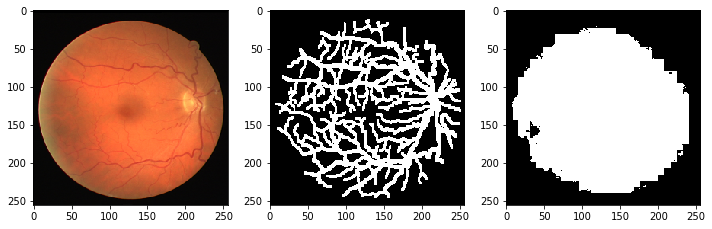

Accuracy= 0.65789795 Precision= 0.46750525 Recall= 0.8821291 MeanIoU= 0.48607257 DiceCoefficient= 0.5905103889235761 HD= 10.723805294763608 MyIoU= 0.0005189732142857142 MAE= 0.34210205


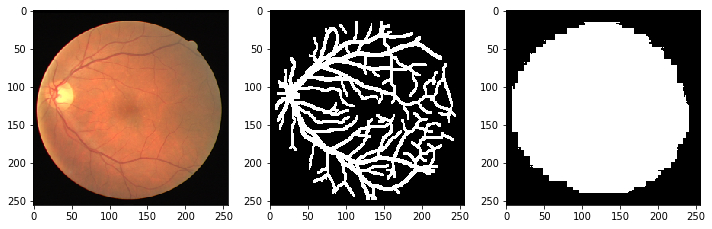

Accuracy= 0.5973053 Precision= 0.37634328 Recall= 0.93348414 MeanIoU= 0.42074913 DiceCoefficient= 0.5468513162777526 HD= 10.583005244258363 MyIoU= 0.0 MAE= 0.4026947


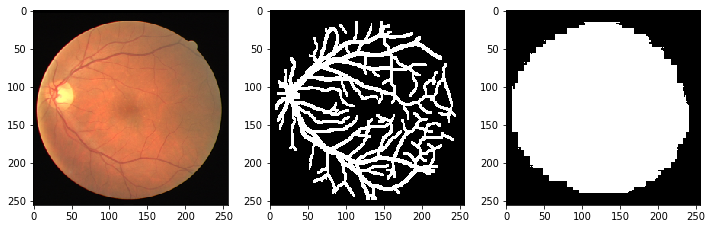

Accuracy= 0.5973053 Precision= 0.37634328 Recall= 0.93348414 MeanIoU= 0.42074913 DiceCoefficient= 0.5468513162777526 HD= 10.583005244258363 MyIoU= 0.0 MAE= 0.4026947


In [522]:
x=0

xx = [1,0,0]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

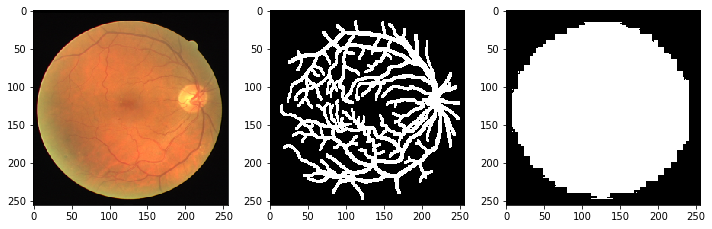

Accuracy= 0.6107178 Precision= 0.40551737 Recall= 0.9610124 MeanIoU= 0.43701863 DiceCoefficient= 0.5760596466716379 HD= 10.862780491200215 MyIoU= 0.000390625 MAE= 0.38928223


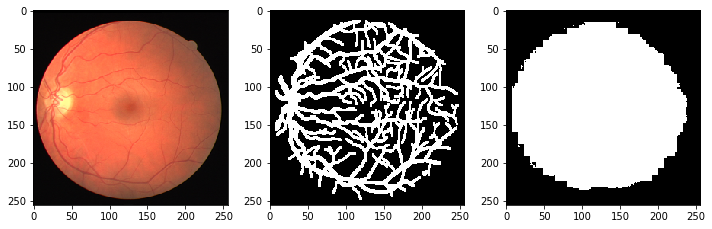

Accuracy= 0.64430237 Precision= 0.46712267 Recall= 0.87525296 MeanIoU= 0.4729349 DiceCoefficient= 0.5951666622568155 HD= 10.816653826391969 MyIoU= 0.001328125 MAE= 0.35569763


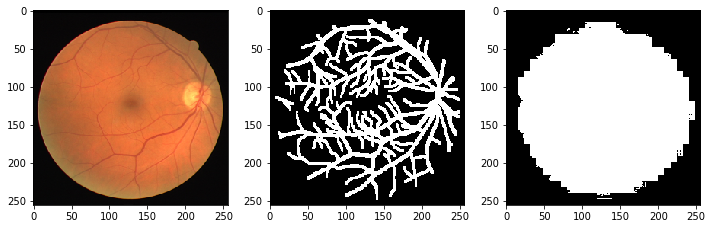

Accuracy= 0.63012695 Precision= 0.43309718 Recall= 0.91979235 MeanIoU= 0.4570799 DiceCoefficient= 0.5761334197013639 HD= 10.583005244258363 MyIoU= 0.0021484375 MAE= 0.36987305


In [523]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3


In [524]:
import winsound
winsound.Beep(2500,1000)